# Import

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline

# Mismatch ddG variances

## Load data

In [2]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_mm_wc.csv', index_col=0)
arr = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)

In [22]:
from nnn import train_nn as tnn
mydata = tnn.MyData()
mydata.load_everything()
arr = mydata.arr

## Calculate ddG

`arr + sl_mm -> df`

In [3]:
df = arr.query("Series == 'External' | Series == 'MisMatches'")

## find parents ##
df['parent'] = df.apply(lambda row: variance.find_mm_parent(row.RefSeq, row.TargetStruct, arr), axis=1)
df.dropna(subset=['parent'], inplace=True)

df['parent1'] = df.parent.apply(lambda x: x[0][0])
df['parent2'] = df.parent.apply(lambda x: x[0][-1] if len(x[0])==2 else None)
df['mismatch1'] = df.parent.apply(lambda x: x[1][0])
df['mismatch2'] = df.parent.apply(lambda x: x[1][-1] if len(x[1])==2 else None)
df['context'] = df.parent.apply(lambda x: x[2])

## massage into long form ##
cols = ['dG_37', 'dG_37_se', 'context']
df_new = pd.DataFrame(index=np.arange(2*len(df)), columns=['SEQID', 'parent', 'mismatch'] + cols)

i = 0
for seqid in df.index:
    for n in [1,2]:
        if df.loc[seqid, 'parent'+str(n)] is not None:
            row = {key:df.loc[seqid, key] for key in cols}
            row['SEQID'] = seqid
            row['parent'] = df.loc[seqid, 'parent'+str(n)]
            row['mismatch'] = df.loc[seqid, 'mismatch'+str(n)]
            df_new.iloc[i,:] = row
            i += 1
            
df = df_new.dropna()
df = df.set_index('parent').join(arr[['dG_37', 'dG_37_se']], rsuffix='_parent').reset_index()
df['flank'] = df.context.apply(lambda x: x[0]+x[-1]+'x'+x[2:4])

## add santalucia ddG ##
df['ddG_37_sl'] = df.apply(lambda row: variance.get_santalucia_mm_ddG(row, sl_mm), axis=1)

## ddG ##
df['ddG_37'] = (df.dG_37 - df.dG_37_parent).astype(float)
df['ddG_37_se'] = (df.dG_37_se + df.dG_37_se_parent).astype(float)

## Technical vs biological variance

On all mismatches:

In [4]:
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var, sigma_model = variance.get_variances(y, sigma, y_hat, regress_sigma=True, verbose=True, return_model=True)

sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
1.09	0.98	0.12	0.97	0.77	0.65	


On one specific kind of mismatch in figure 2b:

In [5]:
tmp_df = df.query('mismatch == "C>T" & flank == "TAxCG"')
y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
_ = variance.get_variances(y, sigma, y_hat, regress_sigma=True, sigma_model=sigma_model)
print('\n======\n')
tmp_df = df.query('mismatch == "T>C" & flank == "TAxTA"')
y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
_ = variance.get_variances(y, sigma, y_hat, regress_sigma=True, sigma_model=sigma_model)

sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
0.74	0.00	0.10	0.64	1.65	1.55	


sigma = 0.06y + 0.16

tot	model	tech	bio	res	?
0.31	0.27	0.15	0.16	0.22	0.07	


## Plots

### ddG scatterplot

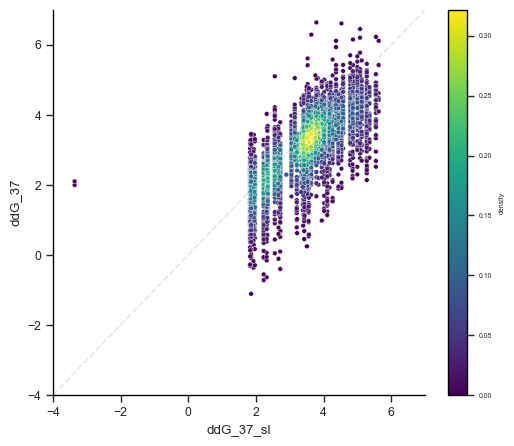

In [6]:
plotting.plot_colored_scatter_comparison(data=df, y='ddG_37', x='ddG_37_sl', 
                                         lim = (-4, 7), color_by_density=True, palette='viridis')
util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_density.pdf')

It gets worse if we look at each mismatch separately:

In [7]:
df = df.query('mismatch != "C>G"')

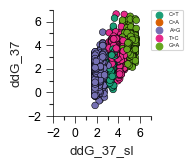

In [8]:
palette = np.array([
    [131,164,255],
    [249,126,43],
    [219,101,210],
    [124,14,221],
    [148,94,234],
]) / 256.
# palette_dict = {mismatch:color for mismatch,color in zip(['A>G', 'C>T'])}

matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim = (-2, 7)
ax.set_xlim(lim)
ax.set_ylim(lim)
sns.scatterplot(data=df, y='ddG_37', x='ddG_37_sl', hue='mismatch', ax=ax, marker='o', edgecolor='k',
                                          palette='Dark2')
sns.despine(trim=False)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_colored_by_mismatch.pdf')

In [9]:
# All data points
r2_score(df.ddG_37, df.ddG_37_sl)

0.308299831291849

In [10]:
# Averages of each mismatch type
df_grouped = df.groupby('mismatch').apply(np.mean)
r2_score(df_grouped.ddG_37_sl, df_grouped.ddG_37)

0.6065179088779726

In [11]:
# T>C only
df_q = df.query('mismatch == "T>C"')
r2_score(df_q.ddG_37_sl, df_q.ddG_37)

-4.203117568508766

In [12]:
# each mismatch
r2_dict = dict()
for mm in df_grouped.index:
    df_q = df.query('mismatch == "%s"' % mm)
    r2_dict[mm] = r2_score(df_q.ddG_37_sl, df_q.ddG_37)
r2_dict

{'A>G': -3.3960513543749737,
 'C>A': 0.0,
 'C>T': -73.38020873004987,
 'G>A': -14.390152470383857,
 'T>C': -4.203117568508766}

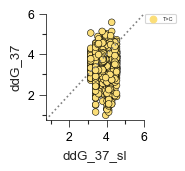

In [13]:
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim = (.75, 6)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.plot(lim, lim, ':', c='gray')
sns.scatterplot(data=df.query('mismatch == "T>C"'), y='ddG_37', x='ddG_37_sl', hue='mismatch', ax=ax, marker='o', edgecolor='k', 
                                          palette=np.array([[252,223,120]])/256.)
sns.despine()
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_ddG_scatter_T>C.pdf')

### Histogram grid

`df -> ddG_df`

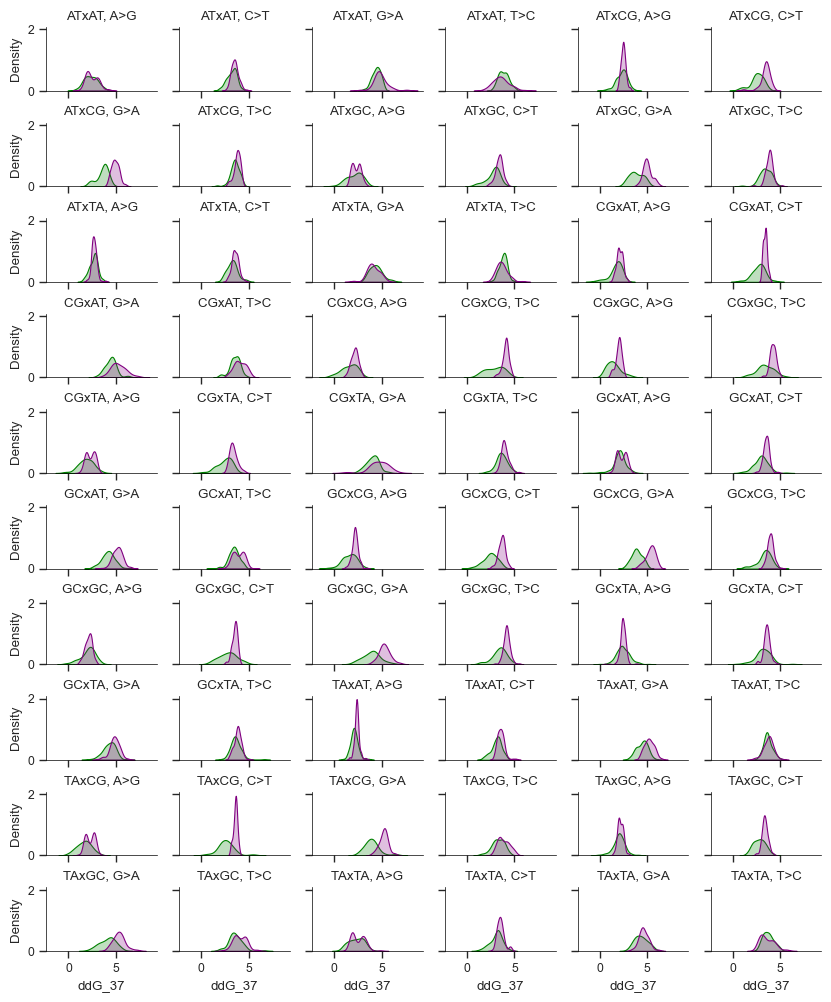

In [14]:
kwargs = dict(fill=True)
flanks, mismatches = np.unique(df.flank), np.unique(df.mismatch)

fig, ax = plt.subplots(10,6,figsize=(10,12), sharey=True, sharex=True)
ax = ax.flatten()

i = 0
ddG_df = pd.DataFrame(columns=['mm', 'ddG_37', 'dop'])

for f in flanks:
    for m in mismatches:
        query = f'flank == "{f}" & mismatch == "{m}"'
        tmp_df = df.query(query).reset_index()
        
        if len(tmp_df) > 10:
            ddG_37_sl_bt = variance.bootstrap_ddG_37_sl(tmp_df)
            sl_bt_df = pd.DataFrame(dict(ddG_37=ddG_37_sl_bt, mm=f'{f}, {m}', dop='sl'))
            arr_ddG_df = pd.DataFrame(dict(ddG_37=tmp_df.ddG_37, mm=f'{f}, {m}', dop='arr'))
            ddG_df = pd.concat([ddG_df, arr_ddG_df, sl_bt_df])
            
            kwargs['ax'] = ax[i]
            ax[i].set_title(f'{f}, {m}')
            sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
            sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
            sns.despine()
            i += 1
        
# plt.legend()
plt.subplots_adjust(hspace=.5)

util.save_fig('./fig/Fig3/mismatch/mm_spread_hist.pdf')

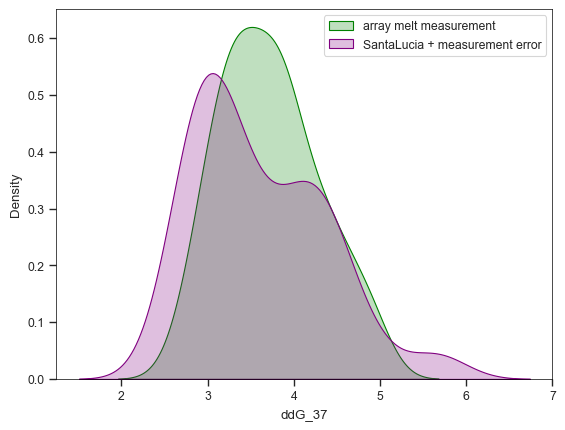

In [15]:
## for legend only ##
kwargs = dict(fill=True)
sns.kdeplot(tmp_df.ddG_37, label='array melt measurement', color='green', **kwargs)
sns.kdeplot(ddG_37_sl_bt, label='SantaLucia + measurement error', color='purple', **kwargs)
plt.legend()
util.save_fig('./fig/Fig3/mismatch/mm_spread_hist_legend.pdf')

### All sorts of variances

`df -> var_df`

In [16]:
var

{'tot': 1.0910124094028193,
 'model': 0.9778481373957576,
 'tech': 0.12019114402891556,
 'bio': 0.9708212653739037,
 'res': 0.7682686566002405,
 '?': 0.648077512571325}

tot	model	tech	bio	res	?
1.09	0.96	0.15	0.95	0.75	0.61	


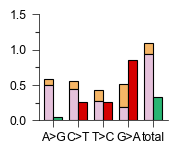

In [17]:
fig, ax = plt.subplots(figsize=(4.25*cm,3.5*cm))
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

mm_list = ['A>G', 'C>T', 'T>C', 'G>A']

metric_dict = dict()
for i,mm in enumerate(mm_list):
    tmp_df = df.query('mismatch == "%s"' % mm)
    y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
    var = variance.get_variances(y, sigma, y_hat, regress_sigma=False, verbose=False)
    variance.plot_variances(var, i, ax=ax, label_text=False, legend=False)
    metric_dict[mm] = (var['bio'] - var['?']) / var['bio']
    plt.axhline(0, color='k', linewidth=.5)
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.tick_params(colors='k', width=.5)
    ax.set_ylim([0,1.5])
    
y = df.ddG_37.values
y_hat = df.ddG_37_sl.values
sigma = df.ddG_37_se.values
var = variance.get_variances(y, sigma, y_hat, verbose=True)
variance.plot_variances(var, i+1, ax, label_text=False)

ax.set_xticks(np.arange(5), mm_list + ['total'])
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.25))

util.save_fig('./fig/Fig3/mismatch/mm_variance_bar_by_mismatch.pdf')

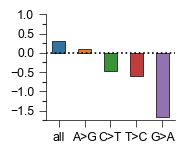

In [18]:
metric_fun = lambda y,y_hat: r2_score(y,y_hat)
metric_dict = dict()
metric_dict['all'] = metric_fun(df.ddG_37, df.ddG_37_sl)
for i,mm in enumerate(['A>G', 'C>T', 'T>C', 'G>A']):
    tmp_df = df.query('mismatch == "%s"' % mm)
    y, sigma, y_hat = tmp_df.ddG_37.values, tmp_df.ddG_37_se.values, tmp_df.ddG_37_sl.values
    metric_dict[mm] = metric_fun(y, y_hat)

fig, ax = plt.subplots(figsize=(4.25*cm, 3.5*cm))
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
ax.tick_params(colors='k', width=.5)

metric_df = pd.DataFrame(metric_dict, index=['metric value'])
sns.barplot(metric_df, ax=ax, width=.5, linewidth=.5, edgecolor='k')
plt.axhline(0, color='k', linestyle=':')
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_minor_locator(MultipleLocator(.25))
ax.set_ylim(top=1)
sns.despine()

util.save_fig('./fig/Fig3/mismatch/mm_r2_bar_by_mismatch.pdf')

In [19]:
metric_df

,all,A>G,C>T,T>C,G>A
metric value,0.3083,0.09468,-0.475483,-0.612247,-1.6587


In [20]:
"""
matplotlib.rc('axes',edgecolor='k', linewidth=.5)
fig, (ax, lax) = plt.subplots(1,2,figsize=(4.25*cm, 3.5*cm), gridspec_kw={"width_ratios":[5,1]})
ax.tick_params(colors='k', width=.5)

lim=[0,1]
ax.plot(lim, lim, ':', c='gray')
sns.scatterplot(data=var_df, x='tot', y='bio',  ax=ax, s=15, edgecolor='k',
                                         hue='mismatch', palette=palette)
ax.set_xlim(lim)
ax.set_ylim(lim)
sns.despine(offset=5)
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(MultipleLocator(.1))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

ax.get_legend().remove()
h,l = ax.get_legend_handles_labels()
lax.legend(h,l, borderaxespad=0, prop={'size': 4})
lax.axis("off")

util.save_fig('./fig/Fig3/mismatch/mm_variance_bio_vs_tot.pdf')
"""
pass

# Variance per position

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Single mismatches

### ddG

In [30]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
arr_mm = arr.query("Series == 'MisMatches'")

## find parents ##
df_with_parent = pd.concat(
    [variance.find_mm_parent_df(arr_mm, arr, '5p'), variance.find_mm_parent_df(arr_mm, arr, '3p')],
    axis=0
)

df_with_parent.drop_duplicates(inplace=True)

### Individual positions

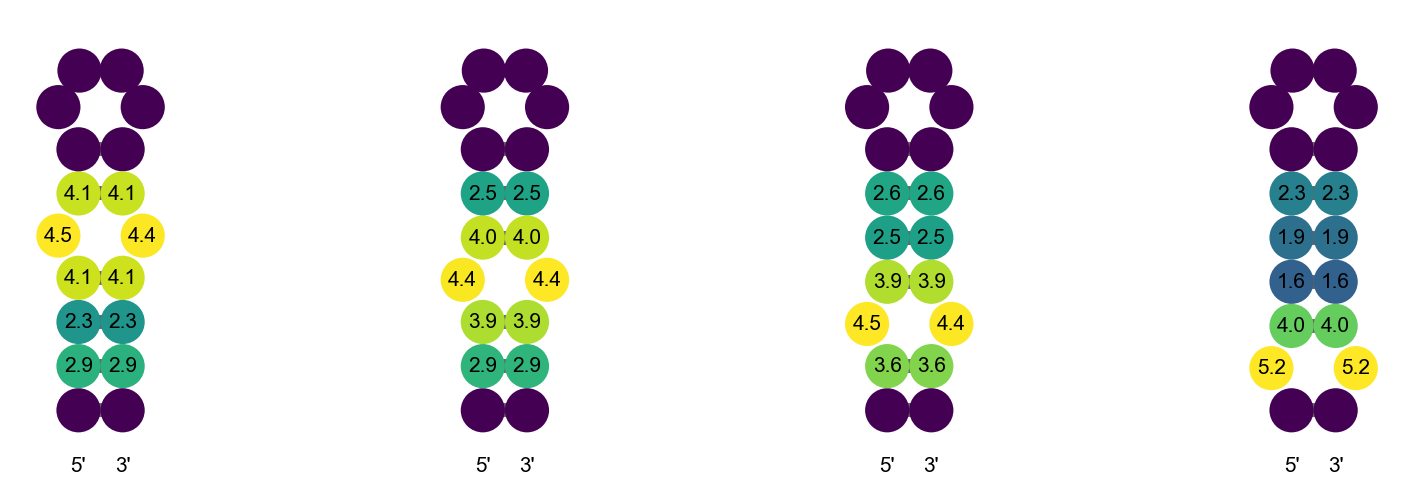

In [32]:
### SET y_col HERE ###
y_col = 'ddG_37_NUPACK_salt_corrected'
# y_col = 'ddG_37'
######################

fig, ax = plt.subplots(1,4, figsize=(20,6))
ax = ax.flatten()

df = df_with_parent.copy()
n = len(df_with_parent.TargetStruct.values[0])
c_log = np.zeros((len(np.unique(df['TargetStruct'])), n))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    n = len(target_struct)
    tmp_df = df[df.TargetStruct == target_struct]
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col=y_col)

    contributions = dict()
    for pos_col in anova_df.columns[:-1]:
        contributions[pos_col] = variance.get_sum_sq_explained(anova_df, pos_col, y_col=y_col)

    c = np.zeros(n)
    for key,value in contributions.items():
        p = int(key.replace('p',''))
        c[p] = np.log(value)
        # c[p] = np.sqrt(value)
    c_log[ind, :] = c
    
    
    variance.plot_contributions_on_struct(contributions, target_struct, clip_max=6.1, ax=ax[ind])
    
util.save_fig(f'./fig/Fig3/importance/single_mm_importance_{y_col}.pdf')

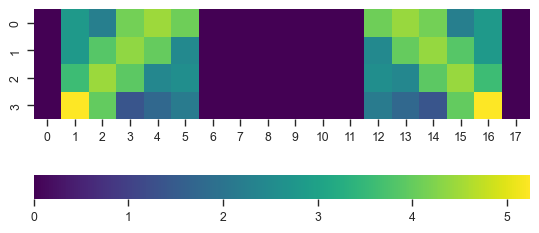

In [33]:
### For the scale bar
sns.heatmap(c_log, cmap='viridis', square=True,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/single_mm_importance_heatmap.pdf')

In [34]:
explained_ratio_indep = np.sum(list(contributions.values())) / np.sum((anova_df[y_col] - np.mean(anova_df[y_col]))**2)
print("%.1f%% of total variance is explained by single nucleotides" % (explained_ratio_indep *100))

48.3% of total variance is explained by single nucleotides


### Pairwise

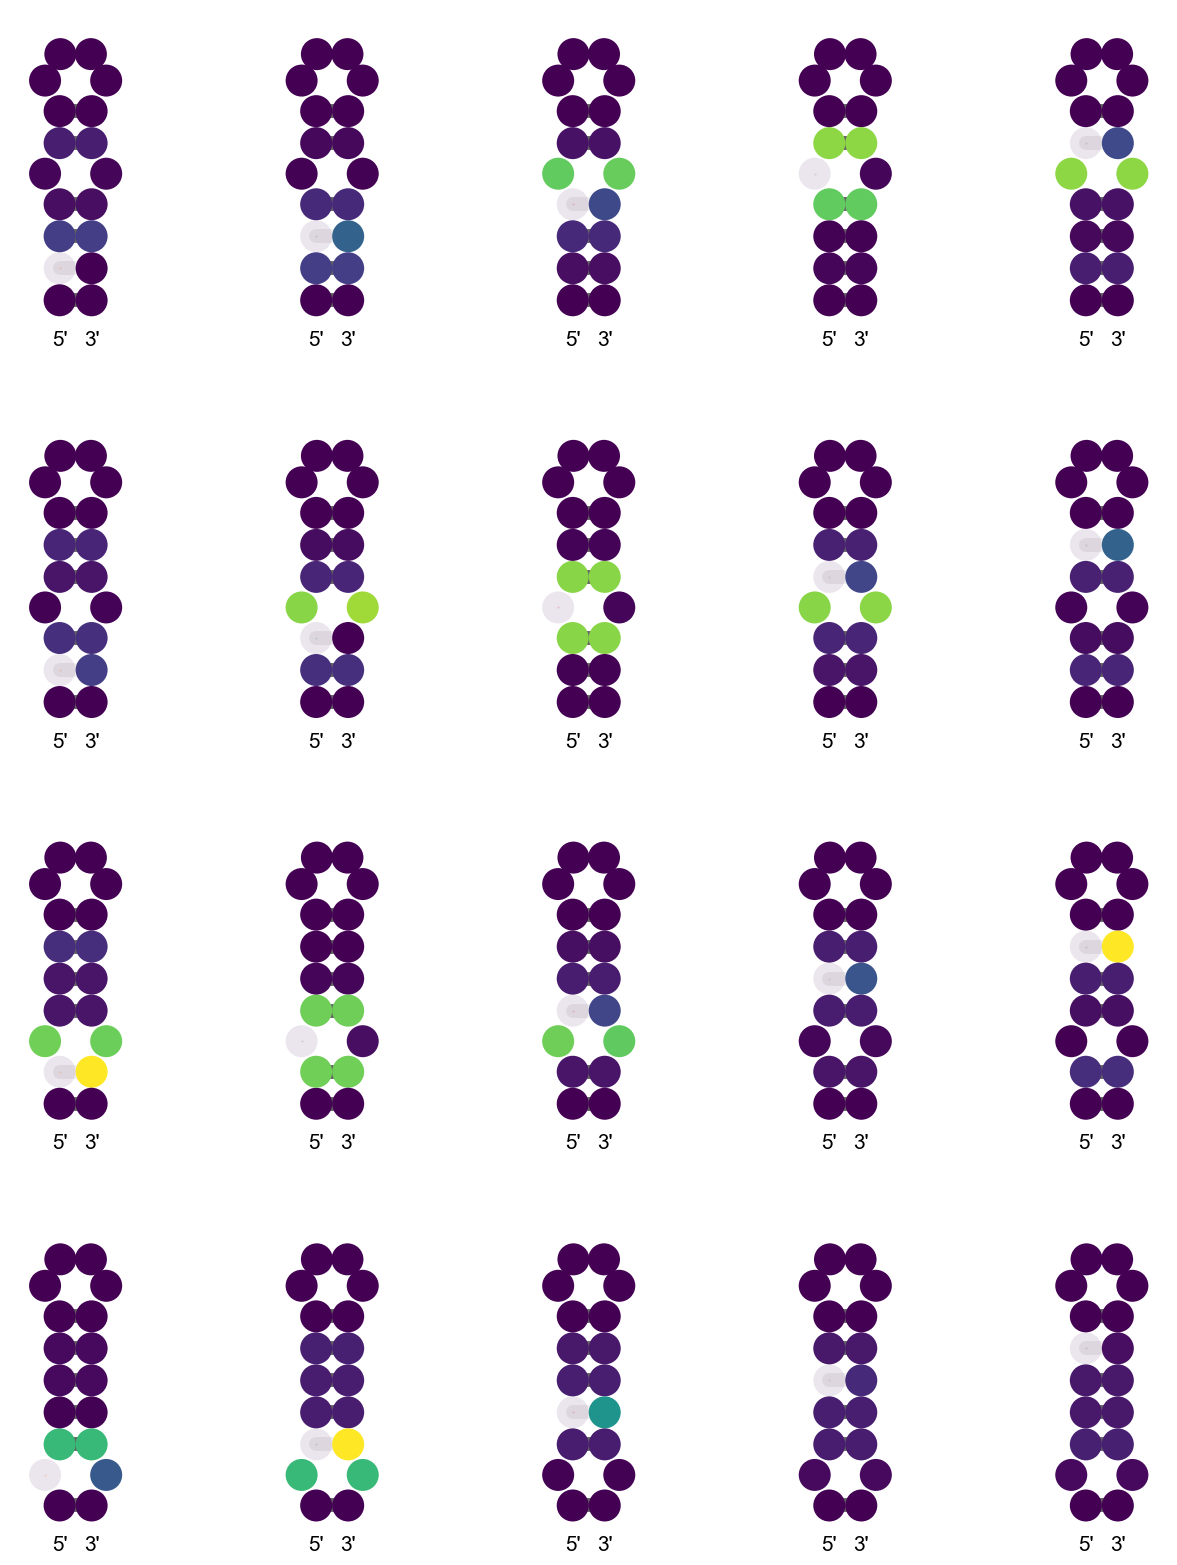

In [35]:
### SET y_col HERE ###
y_col = 'ddG_37_NUPACK_salt_corrected'
# y_col = 'ddG_37'
######################

# fig, ax = plt.subplots(4,5, figsize=(20,20))

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()
decay_dict = {k:[] for k in ['Distance', 'TargetStruct', 'SameSide', 'Anchor', 'Location', 'Interaction', 'MismatchLocation']}

reflect_pos_fun = lambda p: n - int(p) - 1 if int(p) >= n/2 else int(p)
# Reflect the positions on the right side of the hairpin to the left side

anchor_fun = lambda p1, p2: sorted([int(p1), int(p2)])[0]
location_fun = lambda p1, p2: sorted([int(p1), int(p2)])[1]


def sameside_fun(p1, p2): 
    # are they on the same side of the hairpin?
    small, big = sorted([int(p1), int(p2)])
    if (small < n/2) and (big >= n/2):
        return False
    else:
        return True
fig, ax = plt.subplots(4, 5, figsize=(16,20))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    mm_location = target_struct.find('.')
    anova_df = variance.get_pos_df(tmp_df, n=n)
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col=y_col)
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v
        distance = np.abs(reflect_pos_fun(pos1) - reflect_pos_fun(pos2))
        
        decay_dict['Distance'].append(distance)
        decay_dict['TargetStruct'].append(target_struct)
        decay_dict['Interaction'].append(v)
        decay_dict['SameSide'].append(sameside_fun(pos1, pos2))
        decay_dict['Anchor'].append(anchor_fun(pos1, pos2))
        decay_dict['Location'].append(location_fun(pos1, pos2))
        decay_dict['MismatchLocation'].append(mm_location)

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    for p in range(5):
        alpha = np.ones(n)
        alpha[p+1] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p+1,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.03,
                    ax=ax[ind, p])

util.save_fig(f'./fig/Fig3/importance/single_mm_importance_pairwise_{y_col}.pdf')

### Decay

In [36]:
decay_df = pd.DataFrame(decay_dict)
decay_df = decay_df.query('SameSide')

reflect_pos_fun = lambda p: n - int(p) - 1 if int(p) >= n/2 else int(p)
decay_df['Anchor2Mismatch'] = np.abs(decay_df.Anchor.apply(reflect_pos_fun) - decay_df.MismatchLocation)

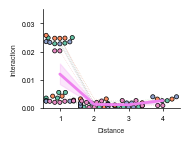

In [45]:
fig, ax = plt.subplots()
sns.swarmplot(
    data=decay_df, 
    x='Distance', y='Interaction', hue='TargetStruct',
    palette='Set2',
    native_scale=True,
    ax=ax,
    edgecolor='k', linewidth=.5, size=3,
)
sns.lineplot(data=decay_df, 
             x='Distance', y='Interaction',
             color='violet', linewidth=2, zorder=10,
             ax=ax
            )

for anchor in np.unique(decay_df.Anchor):
    tmp = decay_df[decay_df.Anchor == anchor]
    for target_struct in np.unique(tmp.TargetStruct):
        ax.plot(
            tmp.query(f'TargetStruct == "{target_struct}"').Distance, 
            tmp.query(f'TargetStruct == "{target_struct}"').Interaction, 
            linestyle=':', alpha=.2, linewidth=.5, zorder=0)

util.beutify(ax, x_locator=1, y_locator=0.01, shrink=True)
ax.set_ylim(bottom=0, top=.035)
ax.set_xlim([.5,4.5])

ax.get_legend().remove()

util.save_fig('./fig/Fig3/interaction_score_decay.pdf')

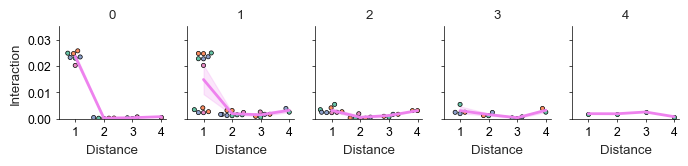

In [46]:
fig, ax = plt.subplots(1,5,figsize=(8,1.2), sharex=True, sharey=True)
for i in range(5):
    sns.swarmplot(
        data=decay_df.query('Anchor2Mismatch == %d'%i), 
        x='Distance', y='Interaction', hue='TargetStruct',
        palette='Set2',
        native_scale=True,
        ax=ax[i],
        edgecolor='k', linewidth=.5, size=3,
    )
    sns.lineplot(data=decay_df.query('Anchor2Mismatch == %d'%i), 
                 x='Distance', y='Interaction',
                 linewidth=2, zorder=10, color='violet',
                 ax=ax[i]
                )
    ax[i].set_ylim(bottom=0, top=.035)
    ax[i].set_title(i)
    ax[i].get_legend().remove()
    
util.beutify_all_ax(ax, x_locator=1, y_locator=.01)
util.save_fig('./fig/Fig3/interaction_score_decay_by_anchor2mm.pdf')

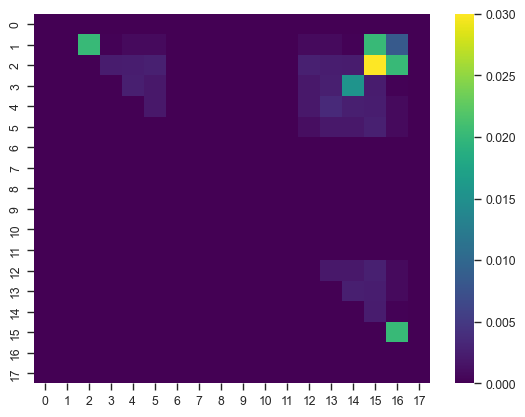

In [47]:
sns.heatmap(c_mat, cmap='viridis', vmin=0, vmax=0.03)
util.save_fig('./fig/Fig3/importance/single_mm_importance_pairwise_cbar.pdf')

In [48]:
within, beyond = np.sum(decay_df.query('Distance <= 1').Interaction), np.sum(decay_df.query('Distance > 1').Interaction)
within_perc = (1 - explained_ratio_indep) * within / (within + beyond)
beyond_perc = (1 - explained_ratio_indep) * beyond / (within + beyond)

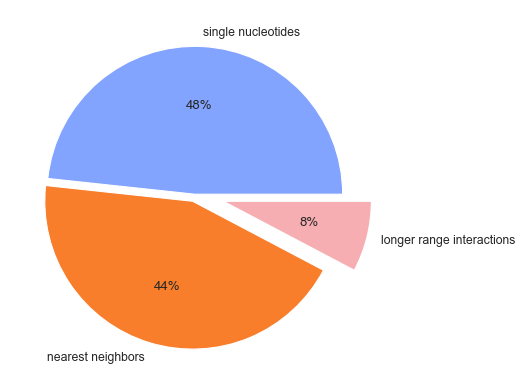

In [49]:
plt.pie([explained_ratio_indep, within_perc, beyond_perc],
        labels=['single nucleotides', 'nearest neighbors', 'longer range interactions'],
        explode=[0,.05, .2],
        colors=np.array([
    [131,164,255],
    [249,126,43],
    [248,175,179],
]) / 256.,
       autopct=lambda x: '%.0f%%'%(x))
util.save_fig('./fig/Fig3/importance/single_mm_variance_nn_vs_beyond.pdf')

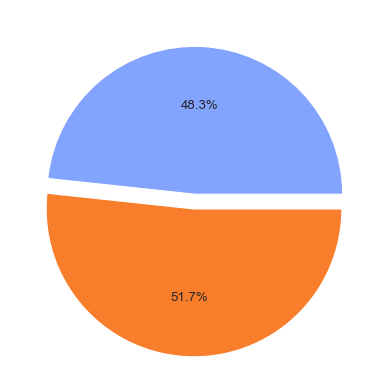

In [50]:
# Ah cannot calculate higher order in this way
plt.pie([explained_ratio_indep, 1 - explained_ratio_indep],
        explode=[0,.1],
        colors=np.array([
    [131,164,255],
    [249,126,43],
]) / 256.,
       autopct=lambda x: '%.1f%%'%(x))
util.save_fig('./fig/Fig3/importance/single_mm_variance_individual_vs_higher_order.pdf')

## WC

### dG individual positions

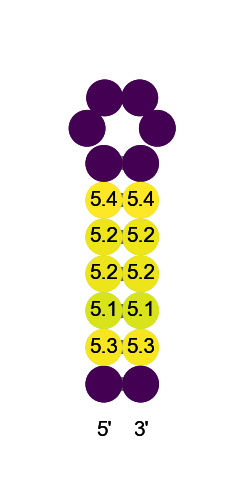

In [51]:
### SET y_col HERE ###
y_col = 'dG_37_NUPACK_salt_corrected'
# y_col = 'dG_37'
######################

fig, ax = plt.subplots(figsize=(5,6))

all_hp_df = arr.query('Series == "WatsonCrick" & ConstructType == "WC_7ntstem"')
target_structs = np.unique(all_hp_df.TargetStruct.values)

for i,target_struct in enumerate(target_structs):
    hp_df = all_hp_df.query('TargetStruct == "%s"'%target_struct)
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col=y_col, ax=ax, vmax=6.1,)
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col=y_col, ax=ax,)
    # Fix vmax to the same as for the mismatches
    
util.save_fig(f'./fig/Fig3/importance/WC_variance_dG_7nt_{y_col}.pdf', fig=fig)

### Pairwise

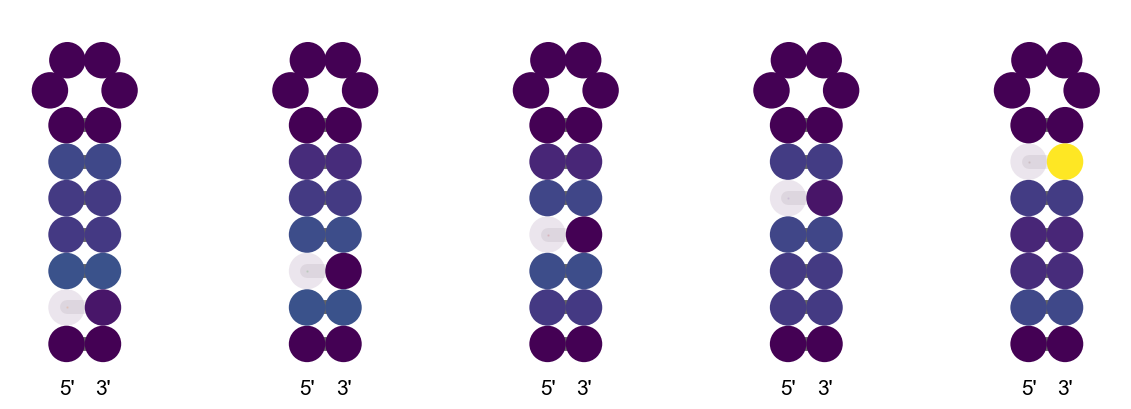

In [52]:
y_col = 'dG_37_NUPACK_salt_corrected'

fig, ax = plt.subplots(1,5, figsize=(15, 5))
ax = ax.reshape(1,5)
df = all_hp_df.copy()

contributions = dict()
decay_dict = {k:[] for k in ['Distance', 'TargetStruct', 'SameSide', 'Anchor', 'Location', 'Interaction']}

def are_sameside(p1, p2, n): 
    # are they on the same side of the hairpin?
    small, big = sorted([int(p1), int(p2)])
    if (small < n/2) and (big >= n/2):
        return False
    else:
        return True

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    
    same_side_fun = lambda p1, p2: are_sameside(p1, p2, n)
    reflect_pos_fun = lambda p: n - int(p) - 1 if int(p) >= n/2 else int(p) # Reflect the positions on the right side of the hairpin to the left side
    anchor_fun = lambda p1, p2: sorted([int(p1), int(p2)])[0]
    location_fun = lambda p1, p2: sorted([int(p1), int(p2)])[1]
    
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col=y_col)
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col=y_col)
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v
        distance = np.abs(reflect_pos_fun(pos1) - reflect_pos_fun(pos2))
        
        decay_dict['Distance'].append(distance)
        decay_dict['TargetStruct'].append(target_struct)
        decay_dict['Interaction'].append(v)
        decay_dict['SameSide'].append(same_side_fun(pos1, pos2))
        decay_dict['Anchor'].append(anchor_fun(pos1, pos2))
        decay_dict['Location'].append(location_fun(pos1, pos2))

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    for p in range(5):
        alpha = np.ones(n)
        
        if n > 14:
            # stem longer than 5bp
            anchor = p + 1
        else:
            # stem = 5bp, no bottom scaffold
            anchor = p
            
        alpha[anchor] = .1
            
        c_rel_2_anchor = c_mat_sym[anchor,:]
        # text_label = ['%.1f' % (1e2*x) for x in c_rel_2_anchor]
        text_label = ['' % (1e2*x) for x in c_rel_2_anchor]
        draw_struct(text_label, target_struct, c=c_rel_2_anchor, alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.03,
                    ax=ax[ind, p])

util.save_fig(f'./fig/Fig3/importance/WC_importance_pairwise_{y_col}.pdf')

### Decay

In [53]:
decay_df = pd.DataFrame(decay_dict)
decay_df = decay_df.query('SameSide')

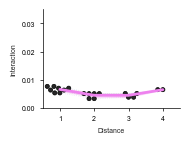

In [54]:
fig, ax = plt.subplots()
sns.swarmplot(
    data=decay_df.query('SameSide'), 
    x='Distance', y='Interaction', hue='TargetStruct',
    color=[.1,.1,.1],
    native_scale=True,
    ax=ax,
    edgecolor='k', linewidth=.5, size=3,
)
sns.lineplot(data=decay_df.query('SameSide'), 
             x='Distance', y='Interaction',
             color='violet', linewidth=2, zorder=10,
             ax=ax
            )

for anchor in np.unique(decay_df.Anchor):
    tmp = decay_df[decay_df.Anchor == anchor]
    for target_struct in np.unique(tmp.TargetStruct):
        ax.plot(
            tmp.query(f'TargetStruct == "{target_struct}"').Distance, 
            tmp.query(f'TargetStruct == "{target_struct}"').Interaction, 
            linestyle=':', alpha=.2, linewidth=.5, zorder=0)

util.beutify(ax, x_locator=1, y_locator=0.01, shrink=True)
ax.set_ylim(bottom=0, top=.035)
ax.set_xlim([.5,4.5])

ax.get_legend().remove()

util.save_fig('./fig/Fig3/WC_interaction_score_decay.pdf')

In [55]:
within, beyond = np.sum(decay_df.query('Distance == 1').Interaction), np.sum(decay_df.query('Distance > 1').Interaction)
within_perc = (1 - explained_ratio_indep) * within / (within + beyond)
beyond_perc = (1 - explained_ratio_indep) * beyond / (within + beyond)

In [56]:
within, beyond

(0.05233896516868464, 0.057266931273076915)

## Individual positions for hairpin loops

### All dG

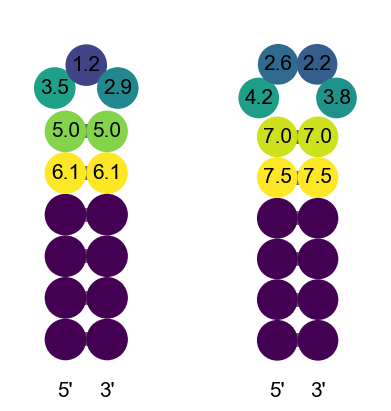

In [57]:
# y_col = 'dG_37'
y_col = 'dG_37_NUPACK_salt_corrected'

fig, ax = plt.subplots(1,2,figsize=(5,5))
ax = ax.flatten()

all_hp_df = arr.query('(Series == "TETRAloop" | Series == "TRIloop") & ConstructType == "NNN"')
target_structs = np.unique(all_hp_df.TargetStruct.values)

for i,target_struct in enumerate(target_structs):
    hp_df = all_hp_df.query('TargetStruct == "%s"'%target_struct)
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col=y_col, ax=ax[i])
    
util.save_fig(f'./fig/Fig3/importance/hairpinloop_variance_dG_{y_col}.pdf', fig=fig)

### All ddG

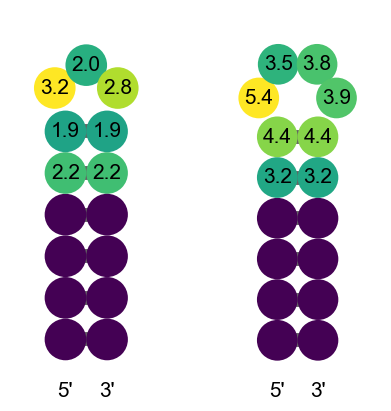

In [58]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax = ax.flatten()

all_hp_df = arr.query('(Series == "TETRAloop" | Series == "TRIloop") & ConstructType == "NNN"')
target_structs = np.unique(all_hp_df.TargetStruct.values)

for i,target_struct in enumerate(target_structs):
    hp_df = all_hp_df.query('TargetStruct == "%s"'%target_struct)
    
    loop_len = target_struct.count('.')
    if loop_len == 3:
        ref_loop_seq = 'TTT'
    elif loop_len == 4:
        ref_loop_seq = 'TAAA'
        
    variance.calc_and_plot_hp_contributions_on_struct(hp_df, arr, y_col='ddG_37', 
                                                      ref_loop_seq=ref_loop_seq, ax=ax[i])
    
util.save_fig('./fig/Fig3/importance/hairpinloop_variance_ddG.pdf', fig=fig)

## Tetraloops

In [59]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "TETRAloop" & ConstructType == "NNN"')

In [60]:
def score_fmt(x, mul=1):
    if x > 1e-6:
        return '%.1f'% (x*mul)
    else:
        return ' '

### ddG

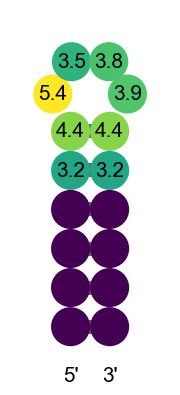

In [61]:
ref_loop_seq = 'TAAA'

variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, ref_loop_seq=ref_loop_seq, y_col='ddG_37')
util.save_fig('./fig/Fig3/importance/tetraloop_variance_ddG.pdf', fig=fig)

### dG

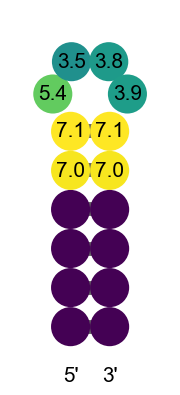

In [62]:
variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, y_col='dG_37')
util.save_fig('./fig/Fig3/importance/tetraloop_variance_dG.pdf')

### Pairwise

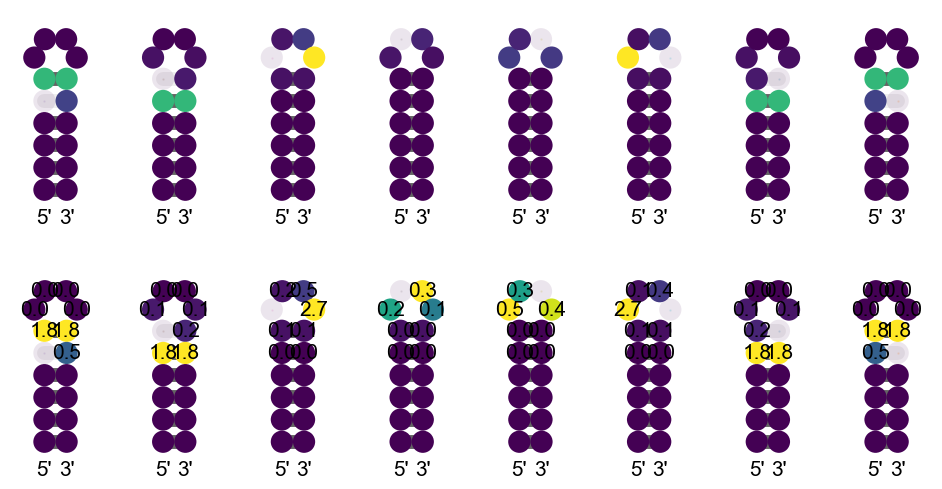

In [63]:
# y_col = 'dG_37'
y_col = 'dG_37_NUPACK_salt_corrected'

df_with_parent = variance.find_hp_parent_df(df_nnn, arr, ref_loop_seq='TAAA')
target_struct = df_with_parent['TargetStruct'].values[0]
n_var_pos = 8
fig, ax = plt.subplots(2,n_var_pos, figsize=(12,6))

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()

tmp_df = df[df.TargetStruct == target_struct]
n = len(target_struct)
anova_df = variance.get_pos_df(tmp_df, n=n)
pos_cols = [c for c in anova_df.columns if c.startswith('p')]

c_mat = np.zeros((n,n))
for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
    v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col=y_col)
    pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
    c_mat[int(pos1), int(pos2)] = v
    contributions[pair] = v

c_mat_sym = c_mat + c_mat.T

vmax = np.max(c_mat_sym.flatten())
    
for ind in range(2):

    for i in range(n_var_pos):
        p = i + 4
        alpha = np.ones(n)
        alpha[p] = 0.1
        text_lbl = [score_fmt(x, mul=1e2) for x in c_mat_sym[p,:]]
        
        if ind == 0:
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, vmax=vmax,
                        ax=ax[ind, i])
        elif ind == 1:
            draw_struct(text_lbl, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, 
                        ax=ax[ind, i])

util.save_fig(f'./fig/Fig3/importance/tetraloop_importance_pairwise_{y_col}.pdf')

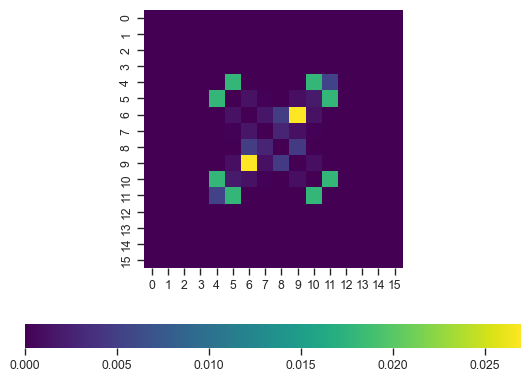

In [64]:
### For the scale bar
sns.heatmap(c_mat_sym, cmap='viridis', square=True, vmax=vmax,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/tetraloop_importance_heatmap.pdf')

In [65]:
def get_c_mat_sym(y_col):
    df_with_parent = variance.find_hp_parent_df(df_nnn, arr, ref_loop_seq='TAAA')
    target_struct = df_with_parent['TargetStruct'].values[0]
    n_var_pos = 8

    df = df_with_parent.copy()
    n = len(df['TargetStruct'].values[0])

    contributions = dict()

    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n)
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]

    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col=y_col)
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    return c_mat_sym

d_c_mat_sym = get_c_mat_sym('dG_37') - get_c_mat_sym('dG_37_NUPACK_salt_corrected')

<Axes: ylabel='Count'>

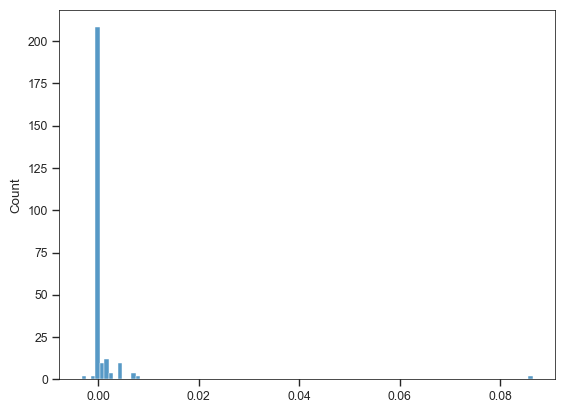

In [66]:
sns.histplot(d_c_mat_sym.flatten(), bins=100)

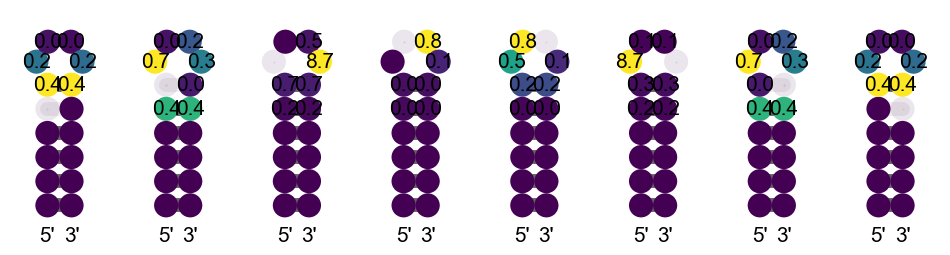

In [67]:
n_var_pos = 8
vmin = np.min(d_c_mat_sym.flatten())
vmax = np.max(d_c_mat_sym.flatten())

fig, ax = plt.subplots(1,n_var_pos, figsize=(12,3))

for i in range(n_var_pos):
    p = i + 4
    alpha = np.ones(n)
    alpha[p] = 0.1
    text_lbl = [score_fmt(x, mul=1e2) for x in d_c_mat_sym[p,:]]

    draw_struct(text_lbl, target_struct, c=d_c_mat_sym[p,:], alpha=alpha,
                cmap='viridis', vmin=0, #vmax=vmax,
                ax=ax[i])
    
util.save_fig(f'./fig/Fig3/importance/tetraloop_importance_pairwise_diff.pdf')

## Triloops

In [68]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "TRIloop" & ConstructType == "NNN"')

### ddG

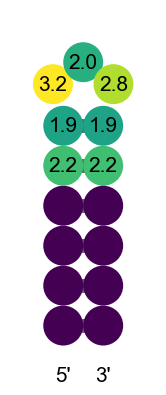

In [69]:
ref_loop_seq = 'TTT'

variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, ref_loop_seq=ref_loop_seq, y_col='ddG_37')
util.save_fig('./fig/Fig3/importance/triloop_variance_ddG.pdf', fig=fig)

### dG

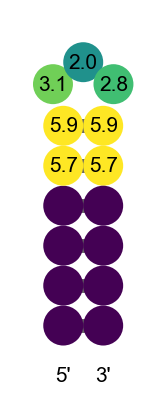

In [70]:
variance.calc_and_plot_hp_contributions_on_struct(df_nnn, arr, y_col='dG_37', clip_max=4)
util.save_fig('./fig/Fig3/importance/triloop_variance_dG.pdf')

### Pairwise

In [71]:
def score_fmt(x, mul=1):
    if x > 1e-6:
        return '%.1f'% (x*mul)
    else:
        return ' '

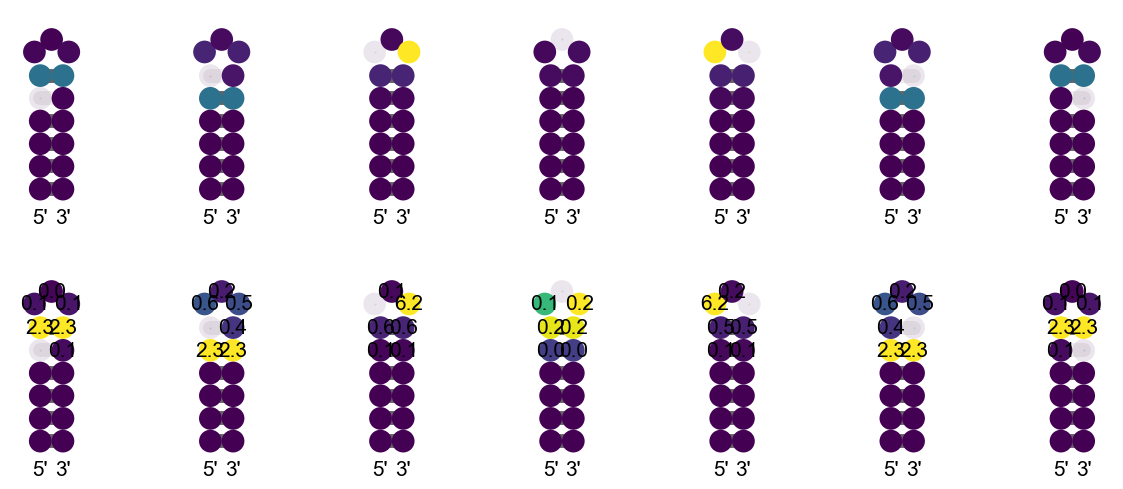

In [72]:
### Set y_col ###
y_col = 'dG_37'
# y_col = 'dG_37_NUPACK_salt_corrected'
#################

df_with_parent = variance.find_hp_parent_df(df_nnn, arr, ref_loop_seq='TTT')
target_struct = df_with_parent['TargetStruct'].values[0]

fig, ax = plt.subplots(2,7, figsize=(15,6))
# ax = ax.flatten()

df = df_with_parent.copy()
n = len(df['TargetStruct'].values[0])

contributions = dict()

tmp_df = df[df.TargetStruct == target_struct]
n = len(target_struct)
anova_df = variance.get_pos_df(tmp_df, n=n)
pos_cols = [c for c in anova_df.columns if c.startswith('p')]

c_mat = np.zeros((n,n))
for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
    v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col=y_col)
    pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
    c_mat[int(pos1), int(pos2)] = v
    contributions[pair] = v

c_mat_sym = c_mat + c_mat.T

vmax = np.max(c_mat_sym.flatten())
    
for ind in range(2):

    for i in range(7):
        p = i + 4
        alpha = np.ones(n)
        alpha[p] = 0.1
        
        if ind == 0:
            # Fixed vmax
            draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, vmax=vmax,
                        ax=ax[ind, i])
        elif ind == 1:
            # Floating vmax
            # text_lbl = ' '*n
            text_lbl = [score_fmt(x, mul=1e2) for x in c_mat_sym[p,:]]
            draw_struct(text_lbl, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                        cmap='viridis', vmin=0, 
                        ax=ax[ind, i])

util.save_fig(f'./fig/Fig3/importance/triloop_importance_pairwise_{y_col}.pdf')

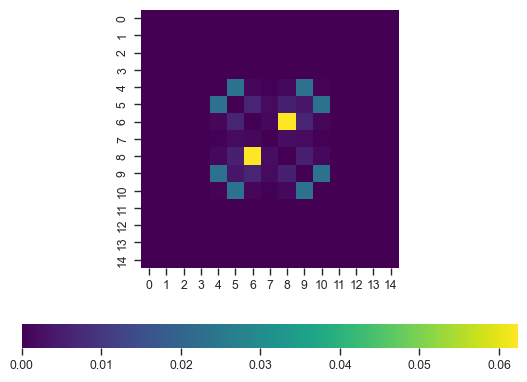

In [73]:
### For the scale bar
sns.heatmap(c_mat_sym, cmap='viridis', square=True, vmax=vmax,
            cbar_kws=dict(orientation='horizontal'))

util.save_fig('./fig/Fig3/importance/triloop_importance_heatmap.pdf')

## Bulges

In [74]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
df_nnn = arr.query('Series == "Bulges" & (ConstructType == "NNN_3primebulge" | ConstructType == "NNN_5prime_bulge")')

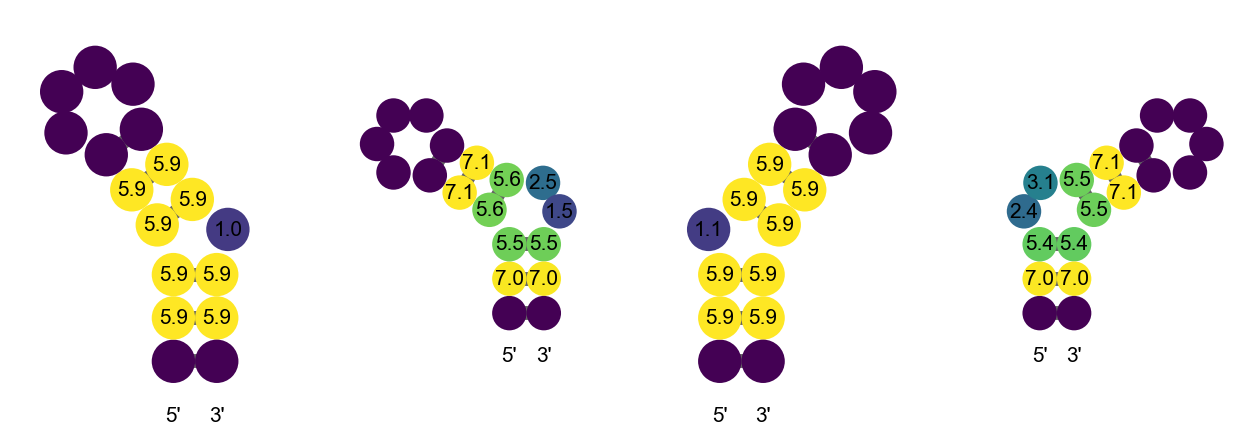

In [75]:
y_col = 'dG_37_NUPACK_salt_corrected'

fig, ax = plt.subplots(1,4, figsize=(16,7))

for i,target_struct in enumerate(np.unique(df_nnn.TargetStruct)):
    contributions = variance.get_single_nt_contributions_df(df_nnn.query('TargetStruct == "%s"'%target_struct), y_col=y_col)
    variance.plot_contributions_on_struct(contributions, target_struct, log_scale=True, ax=ax[i])
    
util.save_fig(f'./fig/Fig3/importance/bulge_importance_{y_col}.pdf')

0.031524165015885175
0.055869904953263605
0.03936997038029344
0.057072930705357794


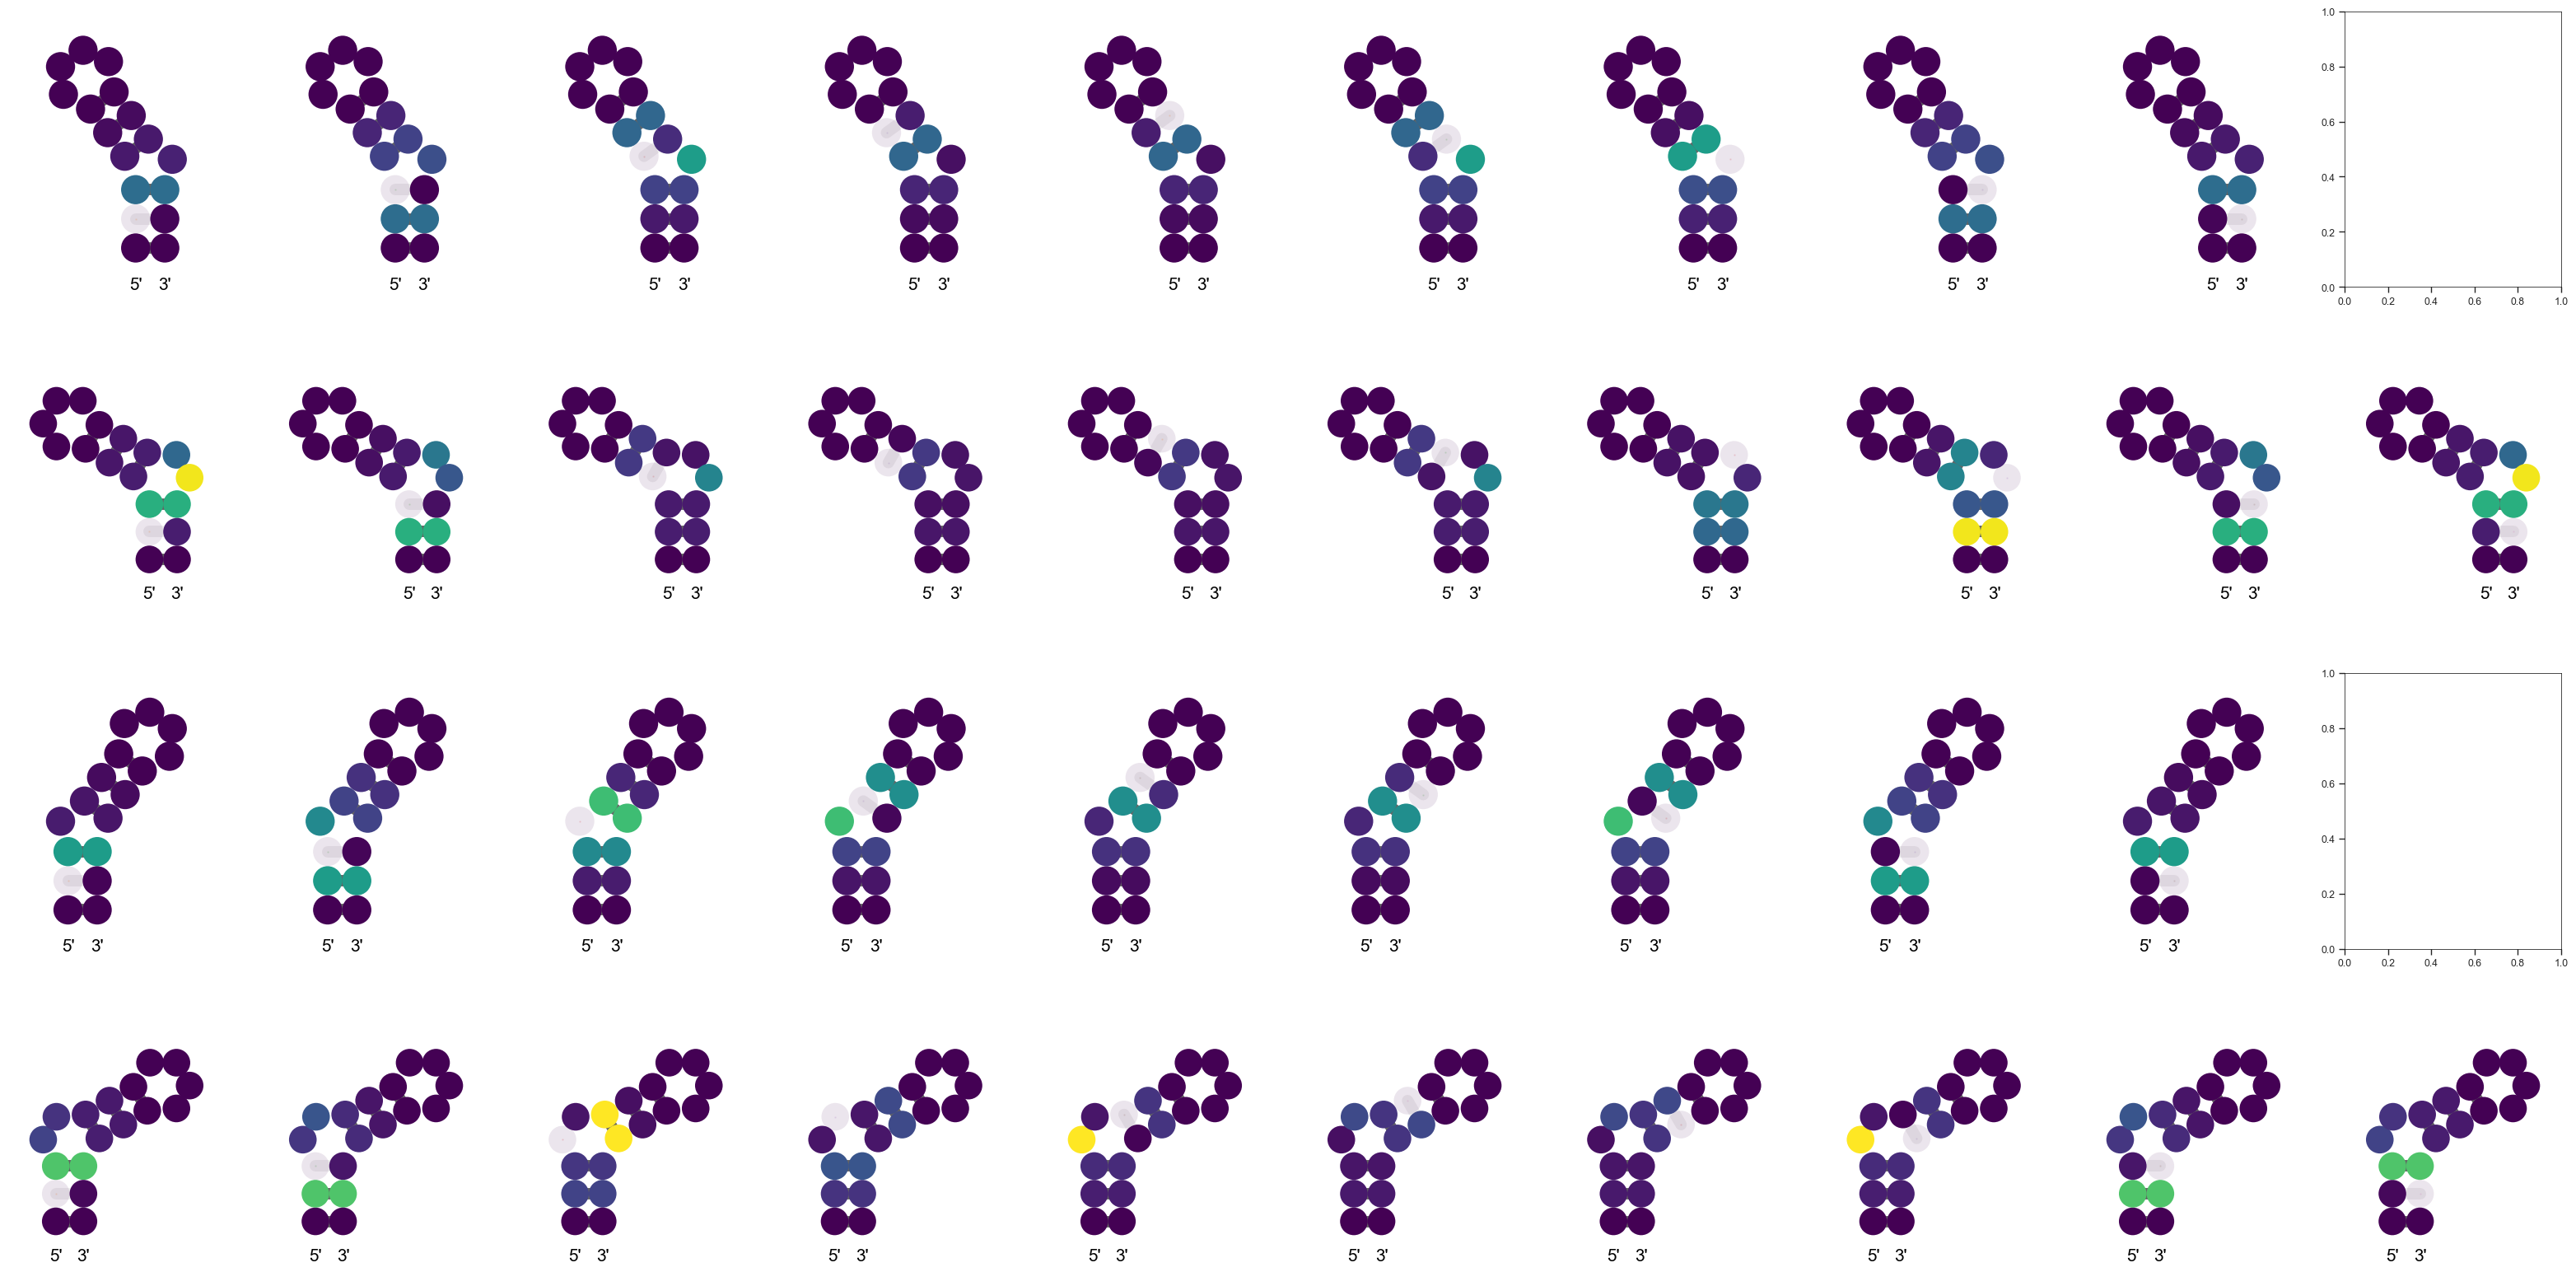

In [76]:
n_pair = 10
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))
# ax = ax.flatten()

df = df_nnn.copy()
n = len(df['TargetStruct'].values[1])

contributions = dict()

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    print(np.max(c_mat_sym.flatten()))
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1

util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise.pdf')

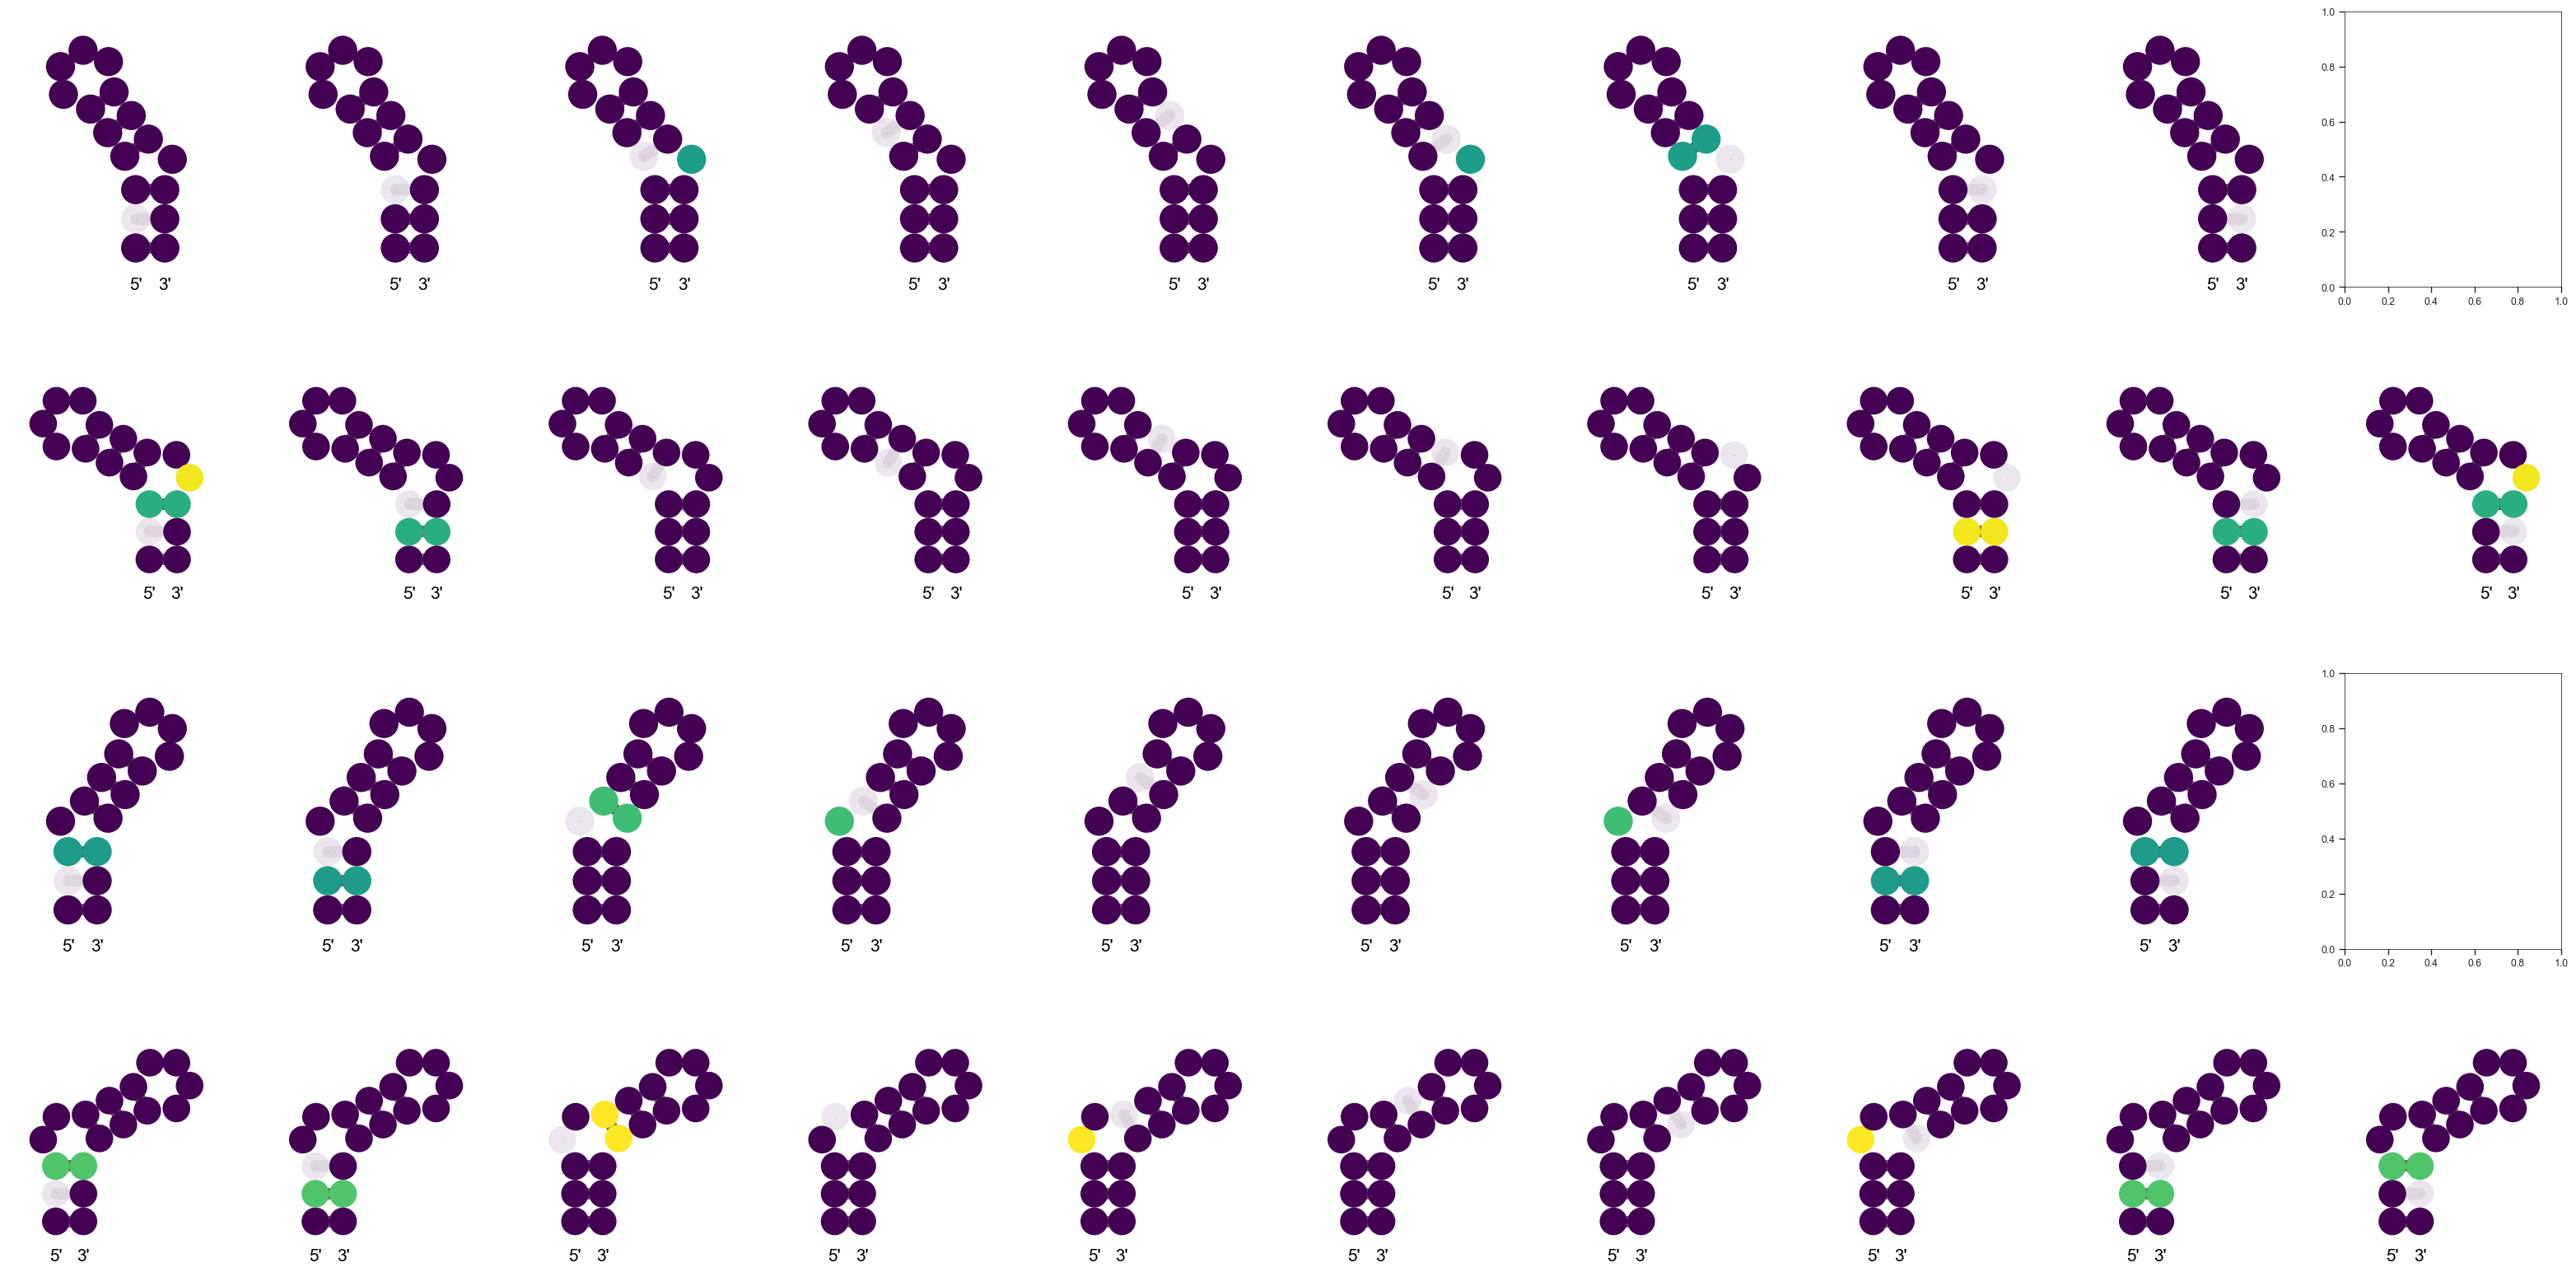

In [77]:
fig, ax = plt.subplots(4,n_pair, figsize=(40,20))

for ind, target_struct in enumerate(np.unique(df['TargetStruct'])):
    tmp_df = df[df.TargetStruct == target_struct]
    n = len(target_struct)
    anova_df = variance.get_pos_df(tmp_df, n=n, y_col='dG_37')
    pos_cols = [c for c in anova_df.columns if c.startswith('p')]
    
    c_mat = np.zeros((n,n))
    for i,pair in enumerate(itertools.combinations(pos_cols, 2)):
        v = variance.get_extra_explained_cp(tmp_df, pair[0], pair[1], y_col='dG_37')
        pos1, pos2 = pair[0].replace('p',''), pair[1].replace('p','')
        c_mat[int(pos1), int(pos2)] = v
        contributions[pair] = v

    c_mat_sym = c_mat + c_mat.T
    # print(np.max(c_mat_sym.flatten()))
    c_mat_sym[c_mat_sym < 0.03] = 0
    k = 0
    for p in [int(x.replace('p','')) for x in pos_cols]:
        alpha = np.ones(n)
        alpha[p] = 0.1
        draw_struct(' '*n, target_struct, c=c_mat_sym[p,:], alpha=alpha,
                    cmap='viridis', vmin=0, vmax=0.057,
                    ax=ax[ind, k])
        k += 1
        
util.save_fig('./fig/Fig3/importance/bulge_importance_pairwise_thresh.pdf')

# Energy contribution from non-MFE

In [78]:
arr = pd.read_csv('./data/models/raw/arr_v0_n=30680.csv', index_col=0)
arr_mm = arr.query("Series == 'MisMatches'")

1 main structure(s), Pr[target] = 0.61, Pr[MFE] = 0.61, Pr[closed] = 0.70, defect = 0.14


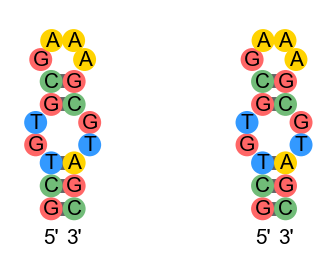

In [80]:
row = arr_mm.iloc[-201,:]
seq = row.RefSeq
struct = row.TargetStruct

# my_model = nupack.Model(material='./models/swift-lake-118.json', celsius=0, sodium=0.088, magnesium=0.0)
my_model = nupack.Model(material='dna04', celsius=0, sodium=0.088, magnesium=0.0)
prob = nupack.structure_probability(strands=[seq], structure=struct, model=my_model)
defect = nupack.defect(strands=[seq], structure=struct, model=my_model)
prob_mat = nupack.pairs(strands=[seq], model=my_model)
prob_end = prob_mat.to_array()[0, -1]
# mfe_structures = nupack.mfe(strands=[seq], model=my_model)
subopt_structures = nupack.subopt(strands=[seq], energy_gap=1, model=my_model)
mfe_struct = str(subopt_structures[0].structure)
fig, ax = plt.subplots(1,2, figsize=(5,3))
draw_struct(seq, struct, ax=ax[0])
draw_struct(seq, mfe_struct,ax=ax[1])
mfe_prob = nupack.structure_probability(strands=[seq], structure=mfe_struct, model=my_model)
print('%d main structure(s), Pr[target] = %.2f, Pr[MFE] = %.2f, Pr[closed] = %.2f, defect = %.2f' % 
      (len(subopt_structures), prob, mfe_prob, prob_end, defect))

In [81]:
def get_breathing(seq, target_struct, material, model=None,
                  celsius=0, sodium=0.088, energy_gap=1,
                  plot_struct=False, verbose=False,):
    if model is None:
        my_model = nupack.Model(material=material, celsius=celsius, sodium=sodium, magnesium=0.0)
    else:
        my_model = model
        
    prob = nupack.structure_probability(strands=[seq], structure=target_struct, model=my_model)
    defect_target = nupack.defect(strands=[seq], structure=target_struct, model=my_model)
    prob_mat = nupack.pairs(strands=[seq], model=my_model)
    prob_end = prob_mat.to_array()[0, -1]
    # mfe_structures = nupack.mfe(strands=[seq], model=my_model)
    subopt_structures = nupack.subopt(strands=[seq], energy_gap=1, model=my_model)
    mfe_struct = str(subopt_structures[0].structure)
    mfe_prob = nupack.structure_probability(strands=[seq], structure=mfe_struct, model=my_model)
    defect_mfe = nupack.defect(strands=[seq], structure=mfe_struct, model=my_model)
    
    if plot_struct:
        fig, ax = plt.subplots(1,2, figsize=(5,3))
        draw_struct(seq, struct, ax=ax[0])
        draw_struct(seq, mfe_struct,ax=ax[1])
        plt.show()
        
    if verbose:
        print('%d major structure(s), Pr[target] = %.2f, Pr[MFE] = %.2f, Pr[closed] = %.2f, defect = %.2f' % 
              (len(subopt_structures), prob, mfe_prob, prob_end, defect))
        
    results = dict(
        n_major_structs=len(subopt_structures),
        prob_target=prob,
        prob_mfe=mfe_prob,
        prob_close=prob_end,
        defect_target=defect_target,
        defect_mfe=defect_mfe,
        mfe_is_target=(target_struct == mfe_struct)
    )
    return results

In [82]:
arr_mm_sample = arr_mm.sample(500)
breathing_list = []
for i,row in arr_mm_sample.iterrows():
    seq = row.RefSeq
    target_struct = row.TargetStruct
    result_dict = get_breathing(seq, target_struct, 'dna04', verbose=False)
    result_dict['SEQID'] = row.name
    breathing_list.append(result_dict)

breathing_df = pd.DataFrame(breathing_list).set_index('SEQID')

<Axes: xlabel='prob_close', ylabel='Count'>

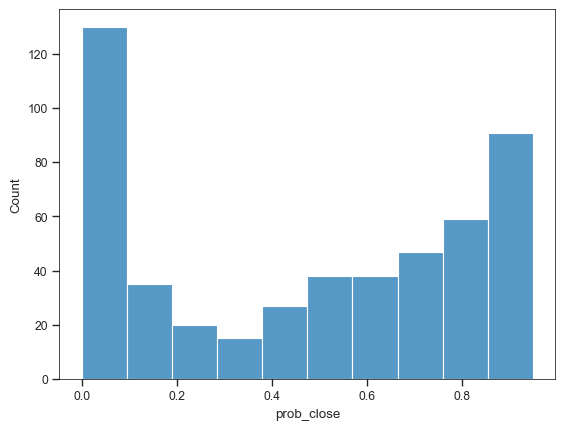

In [84]:
sns.histplot(breathing_df.prob_close)

<Axes: xlabel='prob_mfe', ylabel='Density'>

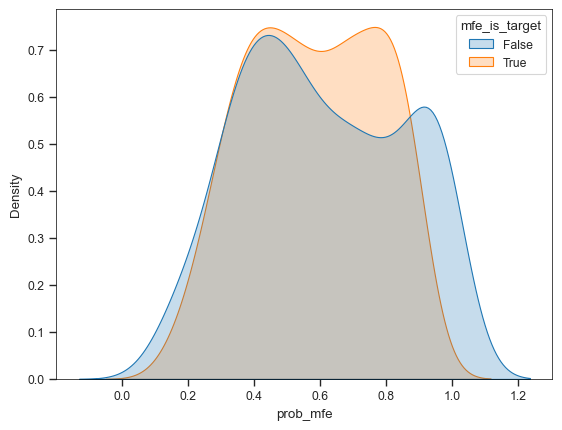

In [85]:
sns.kdeplot(data=breathing_df, x='prob_mfe', hue='mfe_is_target', fill=True)

<Axes: xlabel='n_major_structs', ylabel='Density'>

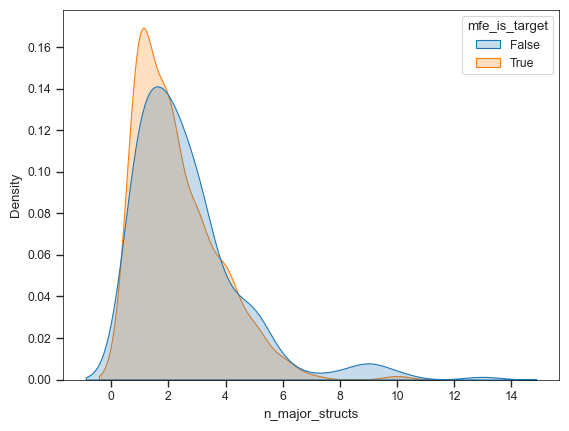

In [86]:
sns.kdeplot(data=breathing_df, x='n_major_structs', hue='mfe_is_target', fill=True)

<Axes: xlabel='prob_close', ylabel='Density'>

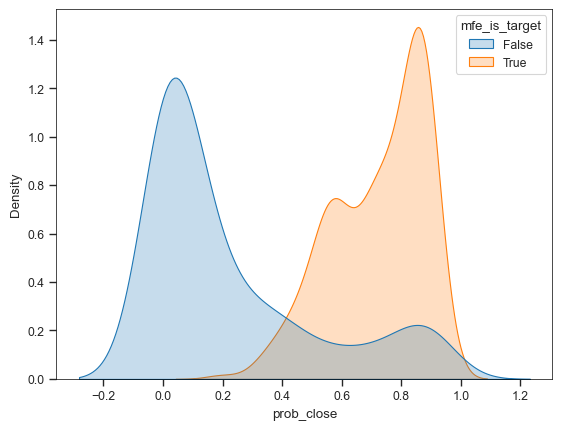

In [87]:
sns.kdeplot(data=breathing_df, x='prob_close', hue='mfe_is_target', fill=True)

<Axes: xlabel='defect_mfe', ylabel='Count'>

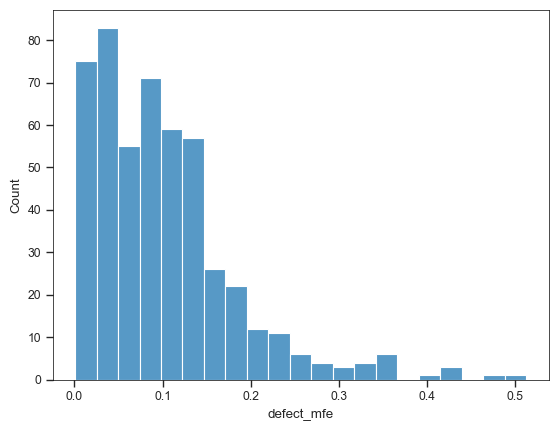

In [88]:
sns.histplot(data=breathing_df, x='defect_mfe')

In [89]:
bfactor = lambda dG: np.exp(-dG)
bfactor(-1), bfactor(-.5), bfactor(0)

(2.718281828459045, 1.6487212707001282, 1.0)